In [2]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [3]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/scripts/pod/configs.json','r',encoding='utf-8') as f:
    PODCONFIGS = json.load(f)
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/scripts/nn/configs.json','r',encoding='utf-8') as f:
    NNCONFIGS = json.load(f)
PODFILEDIR     = PODCONFIGS['paths']['filedir']
PODRESULTSDIR  = PODCONFIGS['paths']['resultsdir']
PODRUN         = PODCONFIGS['runs'][1]
NNFILEDIR      = NNCONFIGS['paths']['filedir']
NNRESULTSDIR   = NNCONFIGS['paths']['resultsdir']
NNRUNS         = NNCONFIGS['runs']
SPLIT          = 'valid'
LANDTHRESH     = 0.5
PRTHRESH       = 0.01

In [4]:
models = []
truepr = xr.open_dataset(os.path.join(PODFILEDIR,f'{SPLIT}.h5'),engine='h5netcdf')['pr'].load()

podpredpr = xr.open_dataset(os.path.join(PODRESULTSDIR,f'pod_{PODRUN["run_name"]}_{SPLIT}_pr.nc'),engine='h5netcdf')['pr'].load()
ytrue,podypred = xr.align(truepr,podpredpr,join='inner')
models.append(('Baseline','Baseline',ytrue,podypred))
for i,run in enumerate(NNRUNS):
    nnpredpr  = xr.open_dataset(os.path.join(NNRESULTSDIR,f'nn_{run["run_name"]}_norm{SPLIT}_pr.nc'),engine='h5netcdf')['pr'].load()
    _,nnypred = xr.align(truepr,nnpredpr,join='inner')
    models.append((run['description'],'NN',ytrue,nnypred))

In [5]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=LANDTHRESH):
    dims = list(ytrue.dims) if dims is None else dims
    if landfrac is not None:
        r2values = []
        for mask in [landfrac>=landthresh,landfrac<landthresh]:
            ssres = ((ytrue.where(mask)-ypred.where(mask))**2).sum(dim=dims,skipna=True)
            sstot = ((ytrue.where(mask)-ytrue.where(mask).mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
            r2values.append(1-ssres/sstot)
        return tuple(r2values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [6]:
def plot_r2_bars(models):
    labels,r2means,r2stds,families = [],[],[],[]
    for label,family,ytrue,ypred in models:
        r2 = get_r2(ytrue,ypred,dims=None)
        if 'member' in ypred.dims:
            r2mean,r2std = r2.mean('member'),r2.std('member')
        else:
            r2mean,r2std = r2,0.0
        labels.append(label)
        families.append(family)
        r2means.append(r2mean)
        r2stds.append(r2std)
    colors = ['blue9' if f=='Baseline' else 'blue3' for f in families]
    fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=2)
    ax.format(suptitle='Baseline vs. NN Skill',xlabel='R$^2$',ylabel='')
    ax.barh(labels,r2means,xerr=r2stds,color=colors,capsize=3)
    pplt.show()

def plot_bias_maps(models,nrows,ncols,latlim=(5,25),lonlim=(60,90)):
    biases,labels = [],[]
    for label,family,ytrue,ypred in models:
        if 'member' in ypred.dims:
            ypredmean = ypred.mean('member')
        else:
            ypredmean = ypred
        bias = (ypredmean-ytrue).mean('time')
        biases.append(bias)
        labels.append(label)
    vmax    = max(float(abs(b).max()) for b in biases)
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,proj='cyl',refwidth=3,share=False)
    axs.format(suptitle='Time-Mean Precipitation Bias',coast=True,latlim=latlim,latlines=5,lonlim=lonlim,lonlines=5)
    for ax,bias,label in zip(np.atleast_1d(axs),biases,labels):
        im = ax.pcolormesh(bias.lon,bias.lat,bias,cmap='ColdHot',vmin=-0.4,vmax=0.4,levels=21,extend='both')
        ax.format(title=label)
    fig.colorbar(im,loc='b',label='Precipitation Bias (mm/hr)')
    for ax in axs[len(biases):]:
        ax.remove()
    pplt.show()

def plot_bias_doy(models):
    nnmodels = [m for m in models if m[1]=='NN']
    nncolors = pplt.Colormap('ColdHot')(np.linspace(0,1,len(nnmodels))) 
    nnidx = 0
    xticks  = [152,166,183,197,214,228,244]
    xlabels = ['Jun 1','Jun 15','Jul 1','Jul 15','Aug 1','Aug 15','Aug 31']
    fig,ax = pplt.subplots(refwidth=6, refheight=2)
    ax.format(suptitle='Daily Climatology of Domain-Mean Precipitation Bias',
              xlabel='Day of Year',xticks=xticks,xticklabels=xlabels,xminorticks='none',
              ylabel='Precipitation Bias (mm/hr)',ylim=(-0.25,0))
    # ax.axhline(0,color='k',linestyle='--',linewidth=1)
    for label,family,ytrue,ypred in models:
        if 'member' in ypred.dims:
            bias = (ypred-ytrue).mean(['lat','lon'])
            clim = bias.groupby('time.dayofyear').mean('time')
            mean,std = clim.mean('member'),clim.std('member')
        else:
            bias = (ypred-ytrue).mean(['lat','lon'])
            mean,std = bias.groupby('time.dayofyear').mean('time'),None
        doy = mean['dayofyear'].values
        if family=='Baseline':
            ax.plot(doy,mean.values,color='k',linewidth=2,label=label,zorder=3)
            continue
        color = nncolors[nnidx]
        nnidx += 1
        if std is not None:
            ax.fill_between(doy,mean.values-std.values,mean.values+std.values,alpha=0.3,color=color)
        ax.plot(doy,mean.values,color=color,linewidth=2,label=label)
    ax.legend(loc='r',ncols=1)
    pplt.show()

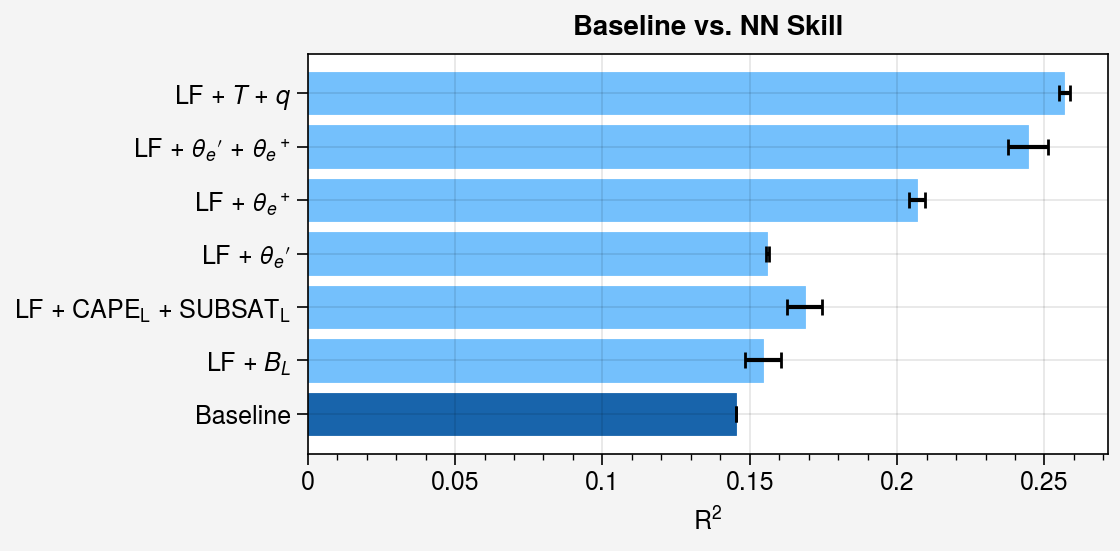

In [7]:
plot_r2_bars(models)

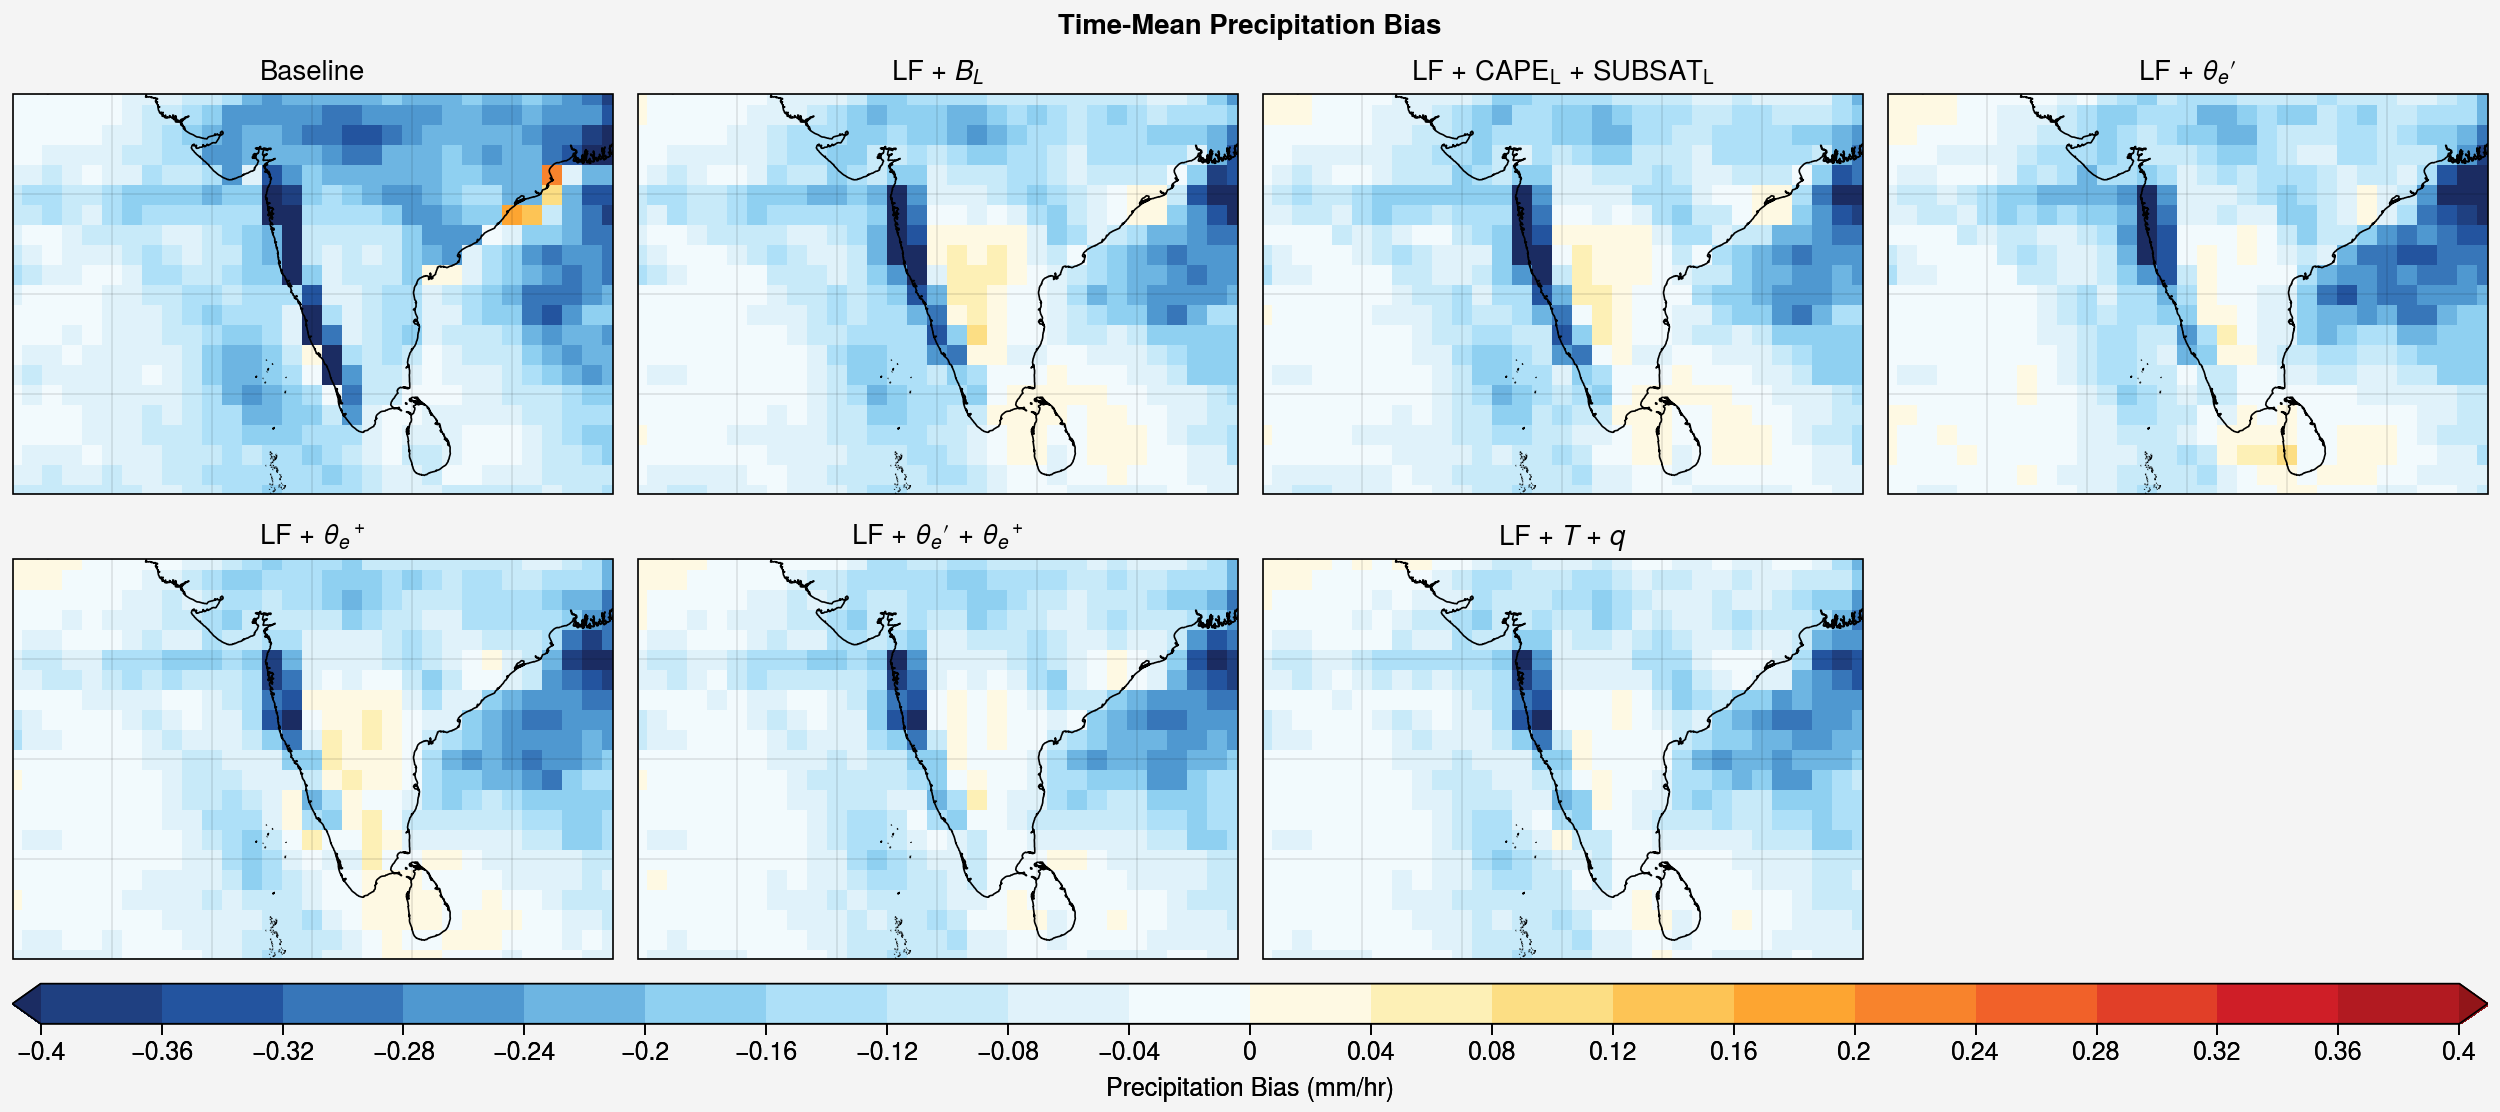

In [8]:
plot_bias_maps(models,nrows=2,ncols=4)

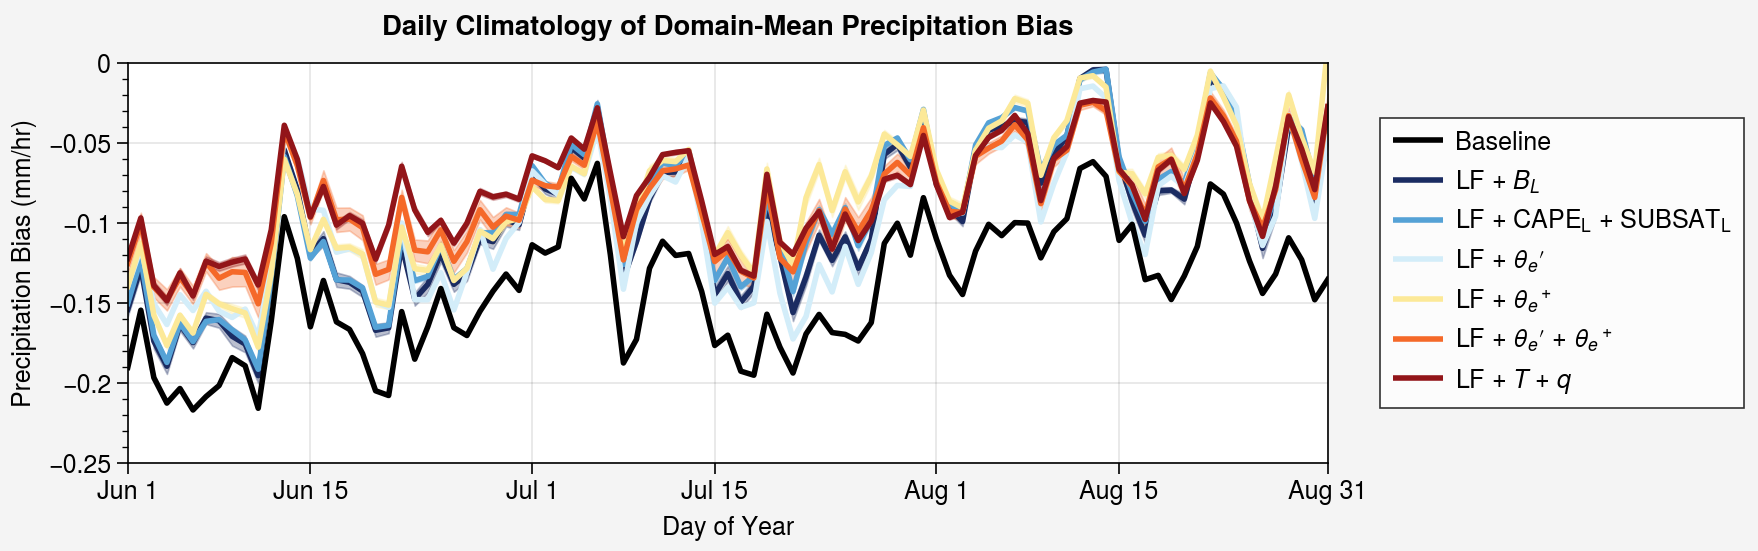

In [9]:
plot_bias_doy(models)